# Data Science Regression Project: Predicting Home Prices in USA

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)

## realtor-data.csv (2,226,382 entries)
- brokered_by (categorically encoded agency/broker)
- status (housing status, either ready for sale or ready to build)
- price (housing price, either the current listing price or recently sold price)
- bed (number of bedrooms)
- bath (number of bathrooms)
- acre_lot (property/land size in acres)
- street (categorically encoded street address)
- city (city name)
- state (state name)
- zip_code (postal code of the area)
- house_size (house area/size/living space in square feet)
- prev_sold_date (last sold date)

https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [5]:
df1 = pd.read_csv('realtor-data.csv')
df1.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [6]:
df1.shape

(2226382, 12)

## Drop Unnecessary Columns

In [8]:
# Limit the location to state for dimensionality reduction
df2 = df1.drop(['brokered_by', 'status', 'prev_sold_date', 'acre_lot', 'street', 'city', 'zip_code'], axis = 'columns')
df2.head()

,price,bed,bath,state,house_size
0,105000.0,3.0,2.0,Puerto Rico,920.0
1,80000.0,4.0,2.0,Puerto Rico,1527.0
2,67000.0,2.0,1.0,Puerto Rico,748.0
3,145000.0,4.0,2.0,Puerto Rico,1800.0
4,65000.0,6.0,2.0,Puerto Rico,NaN


## Data Cleaning: NA Values

In [10]:
df2.isnull().sum()

price           1541
bed           481317
bath          511771
state              8
house_size    568484
dtype: int64

In [11]:
df3 = df2.dropna()
df3 = df3[df3['price'] != 0]
df3 = df3.drop_duplicates()

In [12]:
df3.shape

(1430967, 5)

## Dimensionality Reduction

In [14]:
df3.state = df3.state.apply(lambda x: x.strip())

# Check number of states
print(df3['state'].nunique())

df3.groupby('state')['state'].agg('count')

54


state
Alabama                  18970
Alaska                     880
Arizona                  48235
Arkansas                 11514
California              166282
Colorado                 22510
Connecticut              11634
Delaware                  6513
District of Columbia      5558
Florida                 155400
Georgia                  48035
Guam                       170
Hawaii                    4866
Idaho                    11128
Illinois                 54579
Indiana                  12461
Iowa                     16935
Kansas                   11158
Kentucky                 15851
Louisiana                15931
Maine                     2378
Maryland                 35934
Massachusetts            34397
Michigan                 23754
Minnesota                30662
Mississippi               8352
Missouri                 29896
Montana                   5436
Nebraska                  4513
Nevada                   10294
New Hampshire             2191
New Jersey               22435
Ne

In [15]:
# There's only 50 U.S. states, so we want to group the rest into an "Other" category
# Use a list of the 50 U.S. states to filter out the rest
us_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
    'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 
    'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 
    'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 
    'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]

In [16]:
df3.state = df3.state.apply(lambda x: 'Other' if x not in us_states else x)
len(df3.state.unique())

51

## Outlier Removal: Prices

In [18]:
# Function to remove price outliers per state by one std from mean
def remove_price_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('state'):
        m = np.median(subdf.price)
        st = np.std(subdf.price)
        reduced_df = subdf[(subdf.price>(m-st)) & (subdf.price<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [19]:
df4 = remove_price_outliers(df3)
df4.shape

(1339113, 5)

## Feature Engineering

Add new feature called price_per_sqft

In [22]:
df4['price_per_sqft'] = df4['price']/df4['house_size']
df4.head()

,price,bed,bath,state,house_size,price_per_sqft
0,549000.0,4.0,4.0,Alabama,2919.0,188.078109
1,175000.0,3.0,2.0,Alabama,1234.0,141.815235
2,118500.0,3.0,1.0,Alabama,1276.0,92.868339
3,489900.0,3.0,3.0,Alabama,1840.0,266.250000
4,399900.0,4.0,3.0,Alabama,2709.0,147.619048


## Outlier Removal: Bedroom per Square Feet

In [24]:
df4['bed'].unique()

array([  4.,   3.,   2.,   5.,   1.,   6.,  11.,   7.,   8.,   9.,  12.,
        10.,  14.,  18.,  16.,  13.,  27.,  32.,  22.,  15.,  24.,  55.,
        37.,  20.,  30.,  19.,  17.,  26.,  23.,  25.,  63.,  52.,  35.,
        44.,  28.,  62.,  21.,  34.,  50.,  38.,  49.,  39.,  48.,  40.,
        36.,  33.,  31.,  43.,  66.,  42.,  99.,  41., 190.,  29.,  75.,
       444., 148.])

In [25]:
# Some rows contain a ridiculous number of bedrooms
# but they do not match the house size, likely errors
df4[df4.bed>100]

,price,bed,bath,state,house_size,price_per_sqft
589575,189000.0,190.0,163.0,Louisiana,110350.0,1.712732
970139,440000.0,444.0,222.0,Oregon,1700.0,258.823529
972140,549000.0,148.0,74.0,Oregon,3372.0,162.811388
983846,430000.0,444.0,222.0,Oregon,1700.0,252.941176


In [26]:
df4.groupby('bed')['bed'].agg('count')

bed
1.0       49198
2.0      245751
3.0      599257
4.0      334953
5.0       80075
6.0       18481
7.0        4090
8.0        3403
9.0        1392
10.0        755
11.0        315
12.0        549
13.0        132
14.0        131
15.0        105
16.0        127
17.0         39
18.0         75
19.0         20
20.0         49
21.0         20
22.0         25
23.0         16
24.0         31
25.0         12
26.0          9
27.0          5
28.0         14
29.0          2
30.0          5
31.0          4
32.0         19
33.0          5
34.0          3
35.0          1
36.0          5
37.0          4
38.0          3
39.0          1
40.0          5
41.0          2
42.0          2
43.0          1
44.0          3
48.0          3
49.0          1
50.0          1
52.0          1
55.0          2
62.0          2
63.0          1
66.0          2
75.0          1
99.0          1
148.0         1
190.0         1
444.0         2
Name: bed, dtype: int64

In [27]:
# 300 sq ft is a realistic average for 1 bedroom
# The below are considered outliers
df4[df4.house_size/df4.bed<300].head()

,price,bed,bath,state,house_size,price_per_sqft
5,169000.0,2.0,1.0,Alabama,330.0,512.121212
20,159000.0,3.0,1.0,Alabama,768.0,207.031250
50,72000.0,3.0,1.0,Alabama,756.0,95.238095
61,99999.0,5.0,2.0,Alabama,1345.0,74.348699
162,375000.0,2.0,1.0,Alabama,580.0,646.551724


In [28]:
df4.shape

(1339113, 6)

In [29]:
df5 = df4[~(df4.house_size/df4.bed<300)]
df5.shape

(1321719, 6)

## Outlier Removal: Price Per Square Feet

In [30]:
df5.price_per_sqft.describe()

count    1.321719e+06
mean     2.554881e+02
std      2.203167e+02
min      1.092896e-04
25%      1.383057e+02
50%      1.949686e+02
75%      2.913279e+02
max      8.714286e+03
Name: price_per_sqft, dtype: float64

In [31]:
# Function to remove price per sqft outliers per state by one std from mean
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('state'):
        m = np.median(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [32]:
df6 = remove_pps_outliers(df5)
df6.shape

(1045858, 6)

In [33]:
df6.price_per_sqft.describe()

count    1.045858e+06
mean     2.193149e+02
std      1.226651e+02
min      2.955956e-04
25%      1.401840e+02
50%      1.858744e+02
75%      2.585185e+02
max      1.002639e+03
Name: price_per_sqft, dtype: float64

## Outlier Removal: Price Per Bedroom Outliers

In [35]:
def plot_scatter_chart(df, state):
    twoBed = df[(df.state == state) & (df.bed == 2)]
    threeBed = df[(df.state == state) & (df.bed == 3)]
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(twoBed.house_size, twoBed.price, color = 'blue', label = '2 bedrooms', s = 50)
    plt.scatter(threeBed.house_size, threeBed.price, marker = '+', color = 'green', label = '3 bedrooms', s = 50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price Per Square Feet")
    plt.title(state)
    plt.legend()
    plt.show()

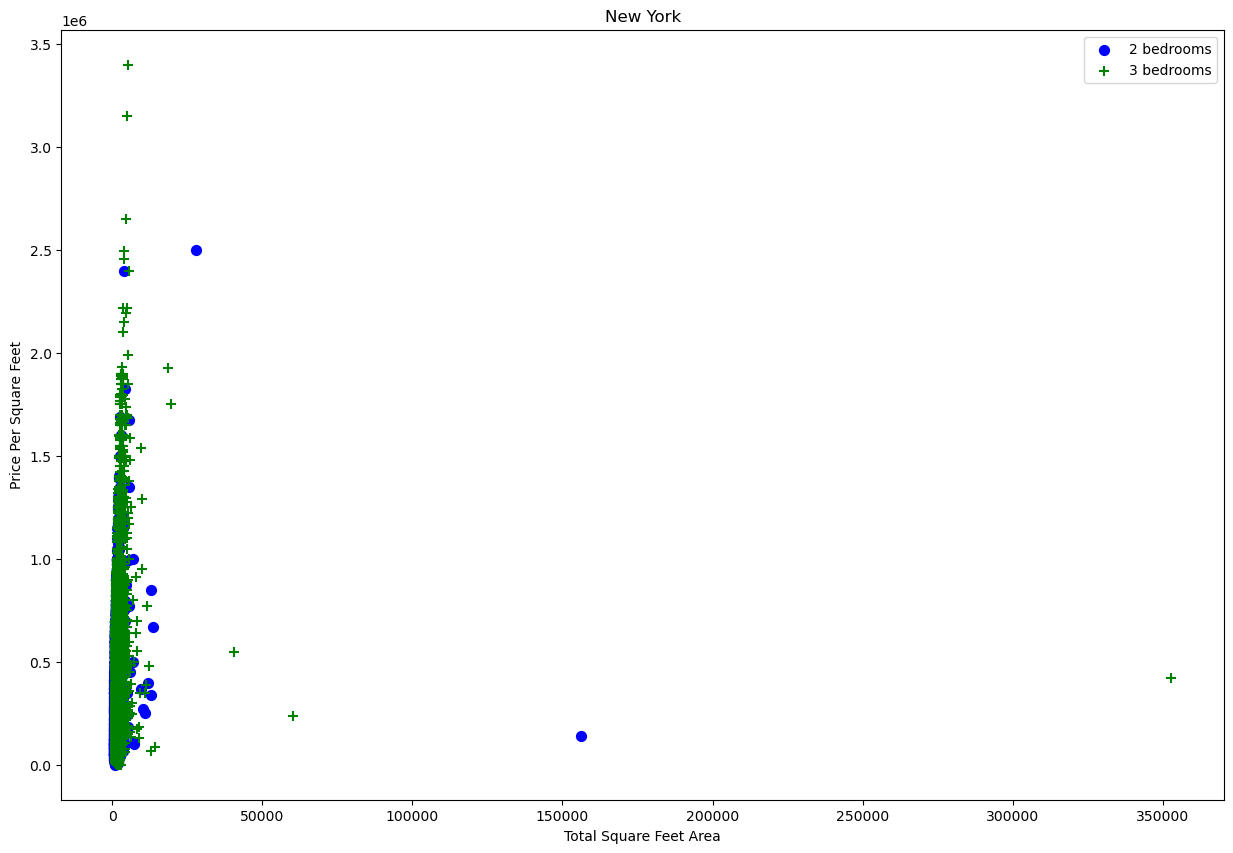

In [36]:
plot_scatter_chart(df6, 'New York')

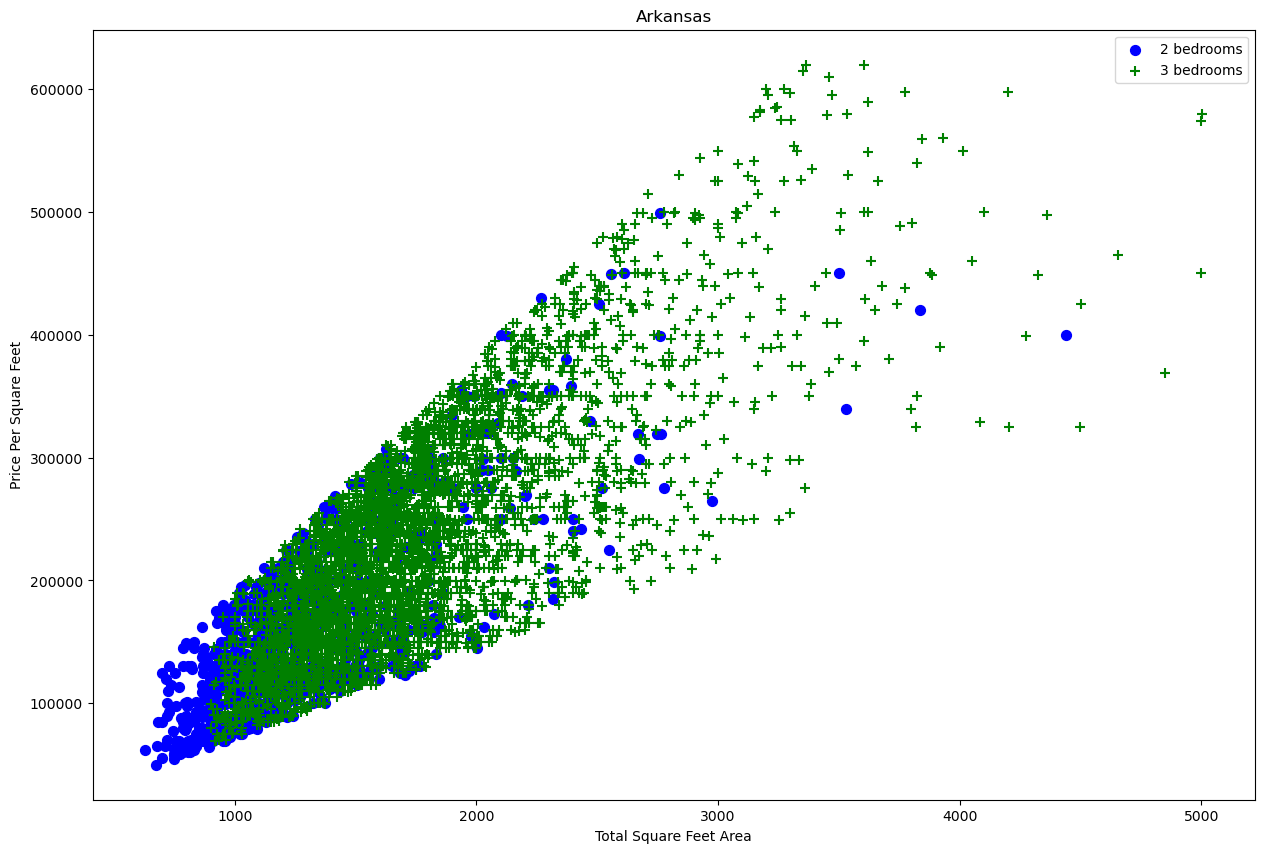

In [37]:
plot_scatter_chart(df6, 'Arkansas')

In [38]:
# Remove bedroom outliers (same state, but 2 bed price is higher than 3 bed, etc.)
def remove_bed_outliers_by_number(df):
    exclude_indices = np.array([])
    for state, state_df in df.groupby('state'):
        bed_stats = {}
        for bed, bed_df in state_df.groupby('bed'):
            bed_stats[bed] = {
                'mean': np.mean(bed_df.price_per_sqft),
                'std': np.std(bed_df.price_per_sqft),
                'count': bed_df.shape[0]
            }
        for bed, bed_df in state_df.groupby('bed'):
            stats = bed_stats.get(bed-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bed_df[bed_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df7 = remove_bed_outliers_by_number(df6)
df7.shape

(485655, 6)

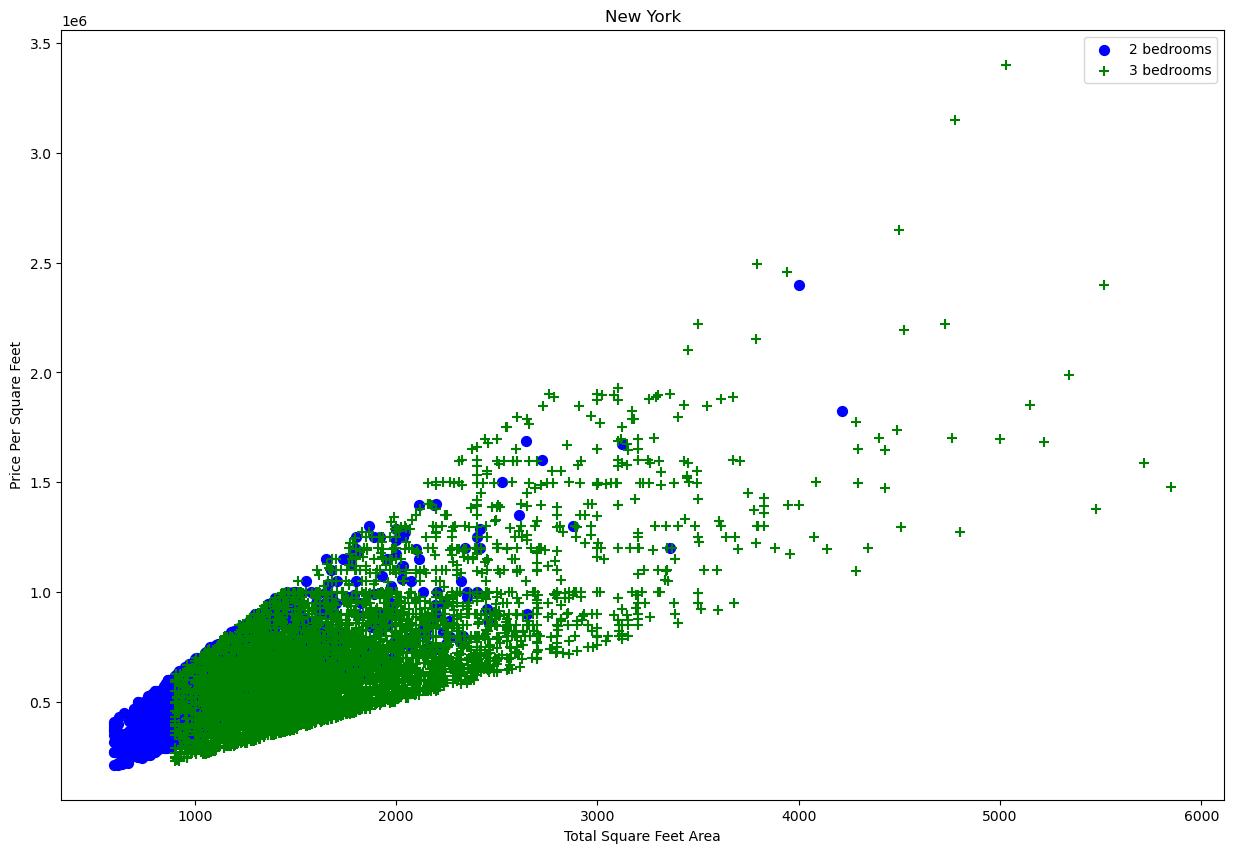

In [39]:
plot_scatter_chart(df7, 'New York')

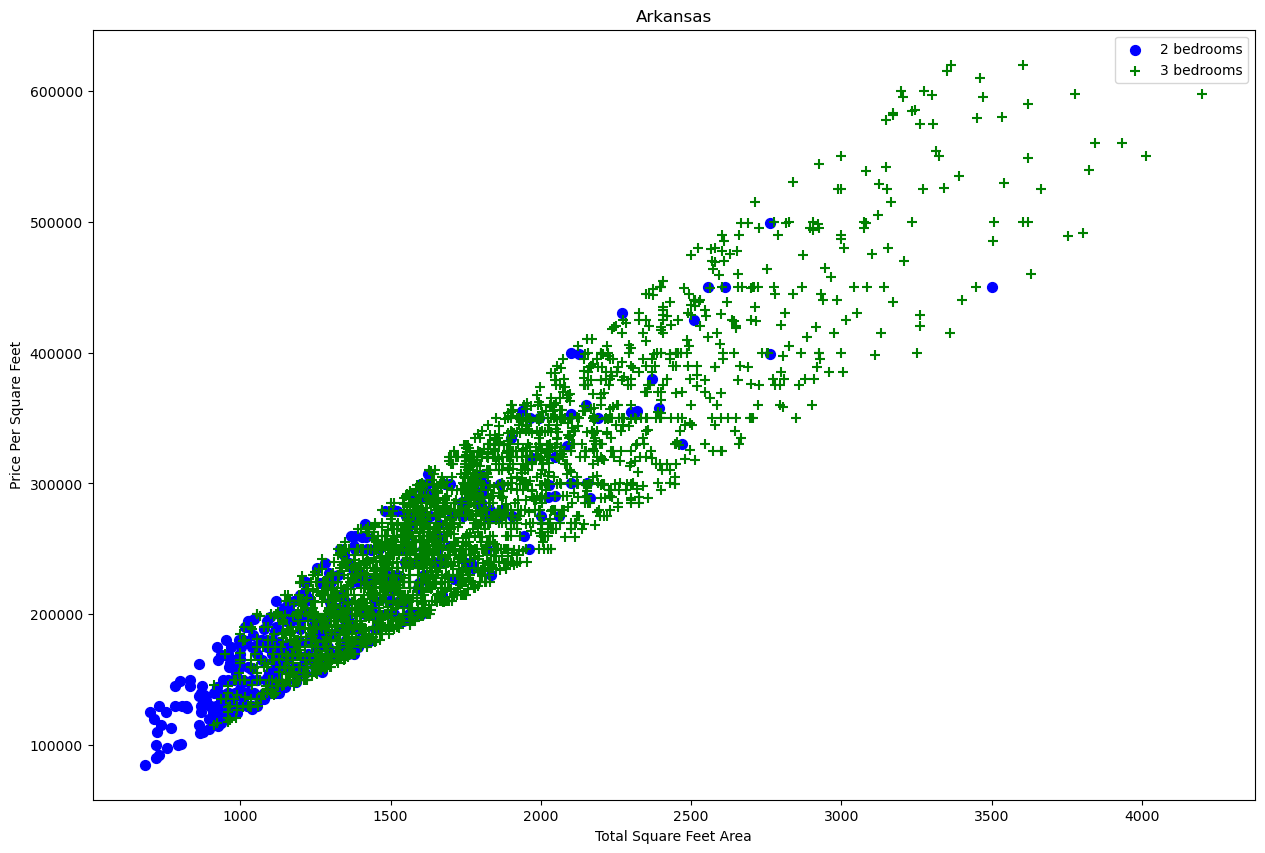

In [40]:
plot_scatter_chart(df7, 'Arkansas')

## Outlier Removal: More Bathrooms than Bedrooms?

In [43]:
df7.bath.unique()

array([  4.,   2.,   3.,   1.,   5.,   6.,   8.,  10.,   7.,  17.,  16.,
         9.,  22.,  13.,  24.,  11.,  12.,  18.,  15.,  70.,  14.,  19.,
        20.,  30.,  32.,  35.,  28.,  38.,  26.,  36.,  44.,  25.,  41.,
        27.,  23.,  42.,  45.,  21.,  29., 113.])

In [131]:
# Unlikely for a house to have 2 more baths than bedrooms
df7[df7.bath>df7.bed+2]

,price,bed,bath,state,house_size,price_per_sqft
14474,685000.0,7.0,17.0,Arizona,2970.0,230.639731
55505,609900.0,4.0,8.0,Arkansas,3500.0,174.257143
56368,5800000.0,13.0,16.0,California,10712.0,541.448842
56769,5995000.0,6.0,24.0,California,15200.0,394.407895
56786,2700000.0,6.0,12.0,California,7026.0,384.286934
...,...,...,...,...,...,...
994594,1219600.0,9.0,12.0,Washington,5034.0,242.272547
1005975,799000.0,1.0,4.0,Washington,3278.0,243.746187
1016327,1085000.0,1.0,4.0,Washington,3420.0,317.251462
1028738,189900.0,1.0,6.0,West Virginia,2080.0,91.298077


In [45]:
df8 = df7[df7.bath<df7.bed+2]
df8.shape

(483553, 6)

In [46]:
df8.price_per_sqft.describe()

count    483553.000000
mean        270.321466
std         140.010748
min           0.621032
25%         176.081200
50%         222.222222
75%         313.617968
max        1002.638522
Name: price_per_sqft, dtype: float64

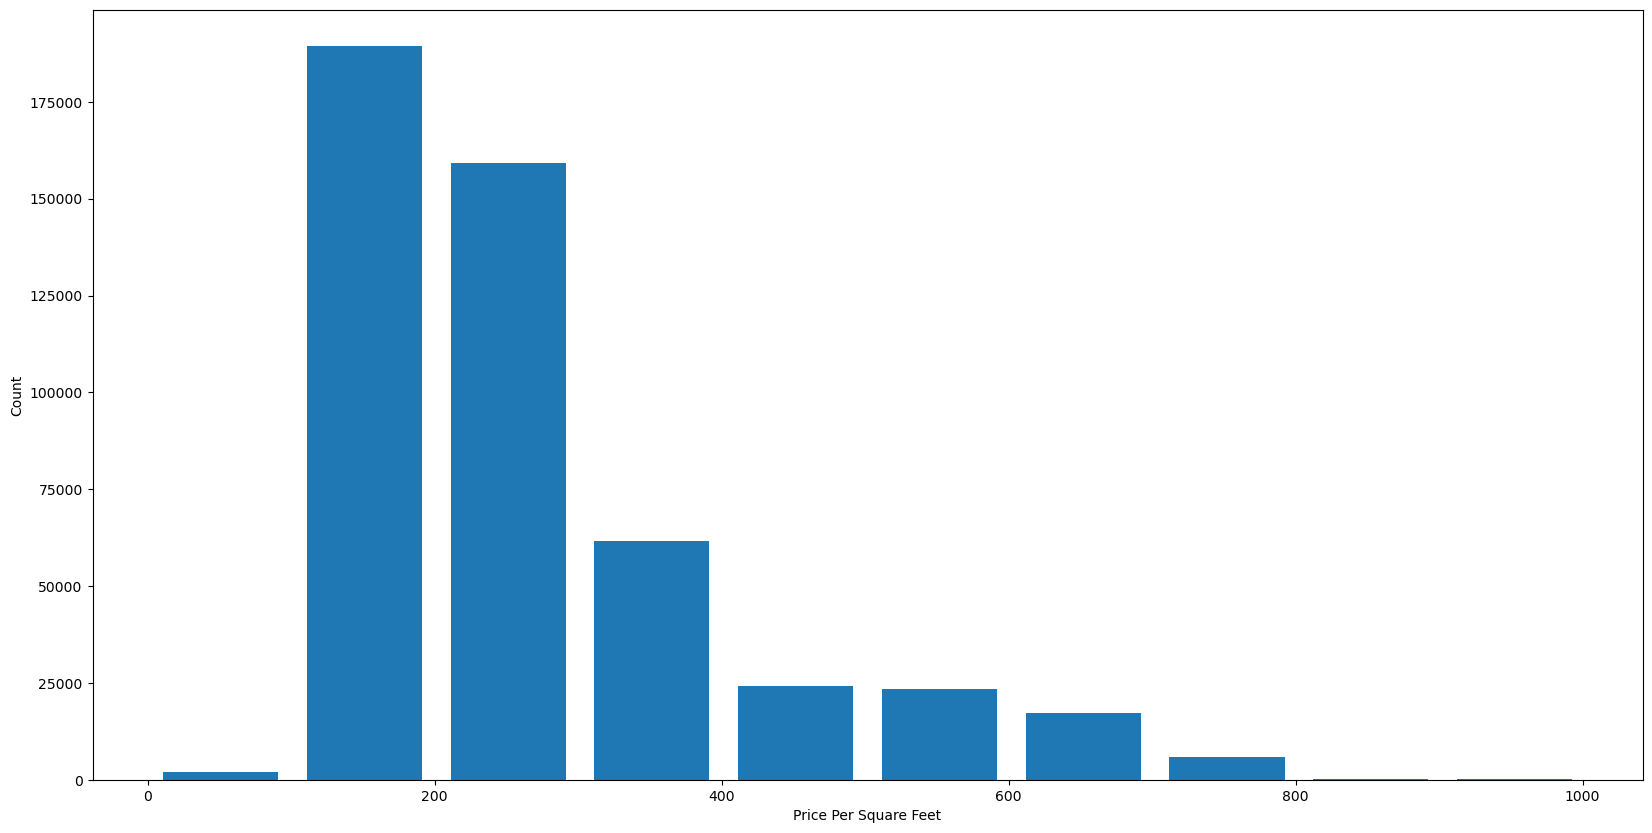

In [133]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
plt.show()

In [47]:
df8.head()

,price,bed,bath,state,house_size,price_per_sqft
0,549000.0,4.0,4.0,Alabama,2919.0,188.078109
1,175000.0,3.0,2.0,Alabama,1234.0,141.815235
3,399900.0,4.0,3.0,Alabama,2709.0,147.619048
4,589000.0,3.0,3.0,Alabama,4108.0,143.378773
5,279000.0,3.0,2.0,Alabama,1917.0,145.539906


In [48]:
# price per sqft is unnecessary at this point
df9 = df8.drop(['price_per_sqft'],axis='columns')
df9.head()

,price,bed,bath,state,house_size
0,549000.0,4.0,4.0,Alabama,2919.0
1,175000.0,3.0,2.0,Alabama,1234.0
3,399900.0,4.0,3.0,Alabama,2709.0
4,589000.0,3.0,3.0,Alabama,4108.0
5,279000.0,3.0,2.0,Alabama,1917.0


## One-Hot Encoding For Each State

In [50]:
dummies = pd.get_dummies(df9.state)
dummies.head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [51]:
df10 = pd.concat([df9, dummies.drop('Other', axis='columns')], axis='columns')
df10.head()

,price,bed,bath,state,house_size,Alabama,Alaska,Arizona,Arkansas,California,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,549000.0,4.0,4.0,Alabama,2919.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,175000.0,3.0,2.0,Alabama,1234.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,399900.0,4.0,3.0,Alabama,2709.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,589000.0,3.0,3.0,Alabama,4108.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,279000.0,3.0,2.0,Alabama,1917.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [52]:
df11 = df10.drop('state', axis='columns')
df11.head()

,price,bed,bath,house_size,Alabama,Alaska,Arizona,Arkansas,California,Colorado,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,549000.0,4.0,4.0,2919.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,175000.0,3.0,2.0,1234.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,399900.0,4.0,3.0,2709.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,589000.0,3.0,3.0,4108.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,279000.0,3.0,2.0,1917.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [53]:
df11.shape

(483553, 54)

## Build Linear Regression Model

In [55]:
X = df11.drop('price', axis='columns')
X.head()

,bed,bath,house_size,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,4.0,4.0,2919.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3.0,2.0,1234.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4.0,3.0,2709.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3.0,3.0,4108.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,3.0,2.0,1917.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [56]:
y = df11.price
y.head()

0    549000.0
1    175000.0
3    399900.0
4    589000.0
5    279000.0
Name: price, dtype: float64

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [58]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8087620731938187

## Use K-Fold Cross-Validation on LinearRegression model

In [60]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.81316742, 0.74627989, 0.81752128, 0.81101241, 0.7370295 ])

In [61]:
X.columns

Index(['bed', 'bath', 'house_size', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object')

## Test Model on Properties

In [63]:
def predict_price(state, bed, bath, sqft):    
    loc_index = np.where(X.columns==state)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = bed
    x[1] = bath
    x[2] = sqft
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [64]:
predict_price('Arkansas', 2, 2, 1000)

C:\Users\justi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


63502.942380954366

In [65]:
predict_price('Arkansas', 3, 3, 1000)

C:\Users\justi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


106350.11599686736

In [66]:
predict_price('New York', 2, 2, 1000)

C:\Users\justi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


521071.2429128873

In [67]:
predict_price('New York', 3, 3, 1000)

C:\Users\justi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


563918.4165288003

## Export the Model to Pickle File

In [69]:
import pickle
with open('usa_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

## Export the Column Data to a JSON File

In [71]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))